In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

C:\Users\jiahaozhang\AppData\Local\Temp\ipykernel_55672\1226147920.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


# Stimulus-driven predictive model of brain activity: Joint training

In [2]:
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict, zip_dict
from src.config import *

%matplotlib inline

In [3]:
import torch
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 1
device#: 0
device name: NVIDIA GeForce RTX 2080

torch: 2.6.0+cu126
cuda:  12.6
cudnn: 90501
dtype: torch.float32


In [4]:
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime()) # 'Aug-10-2020_1638' #

model_name = 'gnet8j_mpf_evc'
model_dir = '%s_%s' % (model_name, timestamp)

output_dir = root_dir+"output/multisubject/%s_%s/" % (model_name,timestamp) 

trn_subjects = [1]
for k,s in enumerate(trn_subjects): 
    subject_dir = output_dir + 'S%02d/'%s
    if not os.path.exists(subject_dir):
        os.makedirs(subject_dir)   
print ("Time Stamp: %s" % timestamp)

Time Stamp: May-04-2025_2344


# Load the stimuli images
From the subjectwise image preparation

In [5]:
exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

image_data = {}
for s in trn_subjects: 
    image_data_set = h5py.File(stim_dir + "S%d_stimuli_227.h5py"%s, 'r')
    image_data[s] = np.copy(image_data_set['stimuli'])
    image_data_set.close()
    print ('--------  subject %d  -------' % s)
    print ('block size:', image_data[s].shape, ', dtype:', image_data[s].dtype, ', value range:',\
           np.min(image_data[s][0]), np.max(image_data[s][0]))

--------  subject 1  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255


## Examples

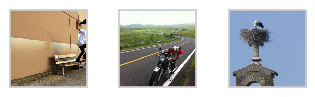

In [6]:
n = 1003
plt.figure(figsize=(4,len(trn_subjects)))
for k,s in enumerate(trn_subjects): 
    for i in range(3):
        plt.subplot(len(trn_subjects), 3, 3*k+i+1)
        plt.imshow(image_data[s][n+i].transpose((1,2,0)), cmap='gray', interpolation='None')
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)

# Load the voxel data
- We load a subset (a range of voxels) of all voxel for the sake of the example.

In [7]:
from src.file_utility import load_mask_from_nii, view_data
from src.roi import roi_map, iterate_roi

In [8]:
beta_dir0 = 'C:/Data/nsd/nsddata_betas/ppdata/'

In [9]:
group_names = ['V1', 'V2', 'V3', 'hV4', 'V3ab', 'LO', 'IPS', 'VO', 'PHC', 'MT', 'MST', 'other']
group = [[1,2],[3,4],[5,6], [7], [16, 17], [14, 15], [18,19,20,21,22,23], [8, 9], [10,11], [13], [12], [24,25,0]]
brain_nii_shape, voxel_mask, voxel_idx, voxel_roi, voxel_ncsnr = {}, {}, {}, {}, {}

for k,s in enumerate(trn_subjects):
    print ('--------  subject %d  -------' % s)
    voxel_mask_full = load_mask_from_nii(mask_dir + "subj%02d/func1pt8mm/brainmask_vcventral_1.0.nii"%s)
    #voxel_mask_full = load_mask_from_nii(mask_dir + "subj%02d/func1pt8mm/brainmask_nsdgeneral_1.0.nii"%s)
    voxel_roi_full  = load_mask_from_nii(mask_dir0 + "subj%02d/func1pt8mm/roi/prf-visualrois.nii.gz"%s)
    voxel_kast_full = load_mask_from_nii(mask_dir0 + "subj%02d/func1pt8mm/roi/Kastner2015.nii.gz"%(s))
    general_mask_full  = load_mask_from_nii(mask_dir0 + "subj%02d/func1pt8mm/roi/nsdgeneral.nii.gz"%(s))
    ncsnr_full = load_mask_from_nii(beta_dir0 + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/ncsnr.nii.gz"%s)
    ###
    brain_nii_shape[s] = voxel_roi_full.shape
    print (brain_nii_shape[s])
    ###
    voxel_roi_mask_full = (voxel_roi_full>0).flatten().astype(bool)
    voxel_joined_roi_full = np.copy(voxel_kast_full.flatten())  # load kastner rois
    voxel_joined_roi_full[voxel_roi_mask_full] = voxel_roi_full.flatten()[voxel_roi_mask_full] # overwrite with prf rois
    ###
    voxel_mask[s]  = np.nan_to_num(voxel_mask_full).flatten().astype(bool)
    voxel_idx[s]   = np.arange(len(voxel_mask[s]))[voxel_mask[s]]
    voxel_roi[s]   = voxel_joined_roi_full[voxel_mask[s]]
    voxel_ncsnr[s] = ncsnr_full.flatten()[voxel_mask[s]]
    print ('full mask length = %d'%len(voxel_mask[s]))
    print ('selection length = %d'%np.sum(voxel_mask[s]))
    for roi_mask, roi_name in iterate_roi(group, voxel_roi[s], roi_map, group_name=group_names):
        print ("%d \t: %s" % (np.sum(roi_mask), roi_name))

--------  subject 1  -------
(81, 104, 83)
full mask length = 699192
selection length = 4657
1350 	: V1
1433 	: V2
1187 	: V3
687 	: hV4
0 	: V3ab
0 	: LO
0 	: IPS
0 	: VO
0 	: PHC
0 	: MT
0 	: MST
0 	: other


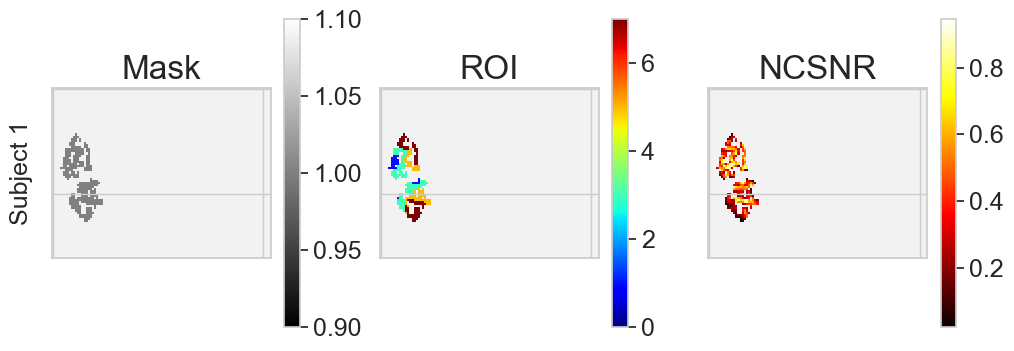

In [10]:
slice_idx = 35
plt.figure(figsize=(12, 4*len(trn_subjects)))
for k,s in enumerate(trn_subjects): 
    subject_dir = output_dir + 'S%02d/'%s
    if not os.path.exists(subject_dir):
        os.makedirs(subject_dir)
    volume_brain_mask = view_data(brain_nii_shape[s], voxel_idx[s], np.ones_like(voxel_idx[s]), save_to=subject_dir+"subj%02d_mask"%s)
    volume_brain_roi  = view_data(brain_nii_shape[s], voxel_idx[s], voxel_roi[s], save_to=subject_dir+"subj%02d_roi"%s)
    volume_ncsnr      = view_data(brain_nii_shape[s], voxel_idx[s], voxel_ncsnr[s], save_to=subject_dir+"subj%02d_ncsnr"%s) 
    ##
    plt.subplot(len(trn_subjects),3,3*k+1)
    plt.imshow(volume_brain_mask[:,:,slice_idx], cmap='gray', interpolation='None')
    plt.title('Mask')
    plt.colorbar()
    _=plt.ylabel('Subject %d'%s)
    _=plt.gca().set_xticklabels([])
    _=plt.gca().set_yticklabels([])
    plt.subplot(len(trn_subjects),3,3*k+2)
    plt.imshow(volume_brain_roi[:,:,slice_idx], cmap='jet', interpolation='None')
    plt.clim([0,7])
    plt.title('ROI')
    plt.colorbar()
    _=plt.gca().set_xticklabels([])
    _=plt.gca().set_yticklabels([])
    plt.subplot(len(trn_subjects),3,3*k+3)
    plt.imshow(volume_ncsnr[:,:,slice_idx], cmap='hot', interpolation='None')
    plt.title('NCSNR')
    plt.colorbar()
    _=plt.gca().set_xticklabels([])
    _=plt.gca().set_yticklabels([])

# Load voxels
Only run one of these cells
## Quick load (Load the voxel data block for these voxels only)

In [11]:
voxel_data_set = h5py.File(voxel_dir+'voxel_data_general_part1_gnet8j.h5py', 'r')
voxel_data_dict = embed_dict({k: np.copy(d) for k,d in voxel_data_set.items()})
voxel_data_set.close()
voxel_data = {int(k): v for k, v in voxel_data_dict['voxel_data'].items()}

# Dataset split and unpacking or averaging
## Reduce the stimulus set to those of which we have responses so far.
- It just so happens that images with index less than 1000 are shared among subjects and are garanteed not to be shown in the remainder. We therefore chose to reparate our training and validation set along these lines.

In [12]:
from src.load_nsd import image_feature_fn, ordering_split
trn_stim_ordering, trn_voxel_data, val_stim_ordering, val_voxel_data = {},{},{},{}

stim_data = {}
data_size, nnv = {}, {}
for k,s in enumerate(trn_subjects):
    print ('--------  subject %d  -------' % s)
    data_size[s], nnv[s] = voxel_data[s].shape      
    stim_data[s] = image_feature_fn(image_data[s])
    
    trn_stim_ordering[s], trn_voxel_data[s], \
    val_stim_ordering[s], val_voxel_data[s] = \
        ordering_split(voxel_data[s], ordering, combine_trial=False)
    
del image_data
del voxel_data

--------  subject 1  -------
Total number of voxels = 4657


In [22]:
trn_stim_mean = sum([np.mean(stim_data[s], axis=(0,2,3), keepdims=True) for s in trn_subjects])/len(trn_subjects)
print (trn_stim_mean)

[[[[0.47845292]]

  [[0.45531794]]

  [[0.41433865]]]]


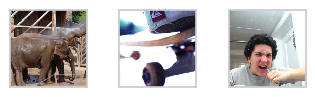

In [15]:
n = 1006
plt.figure(figsize=(4,1*len(trn_subjects)))
for k,s in enumerate(trn_subjects): 
    for i in range(3):
        plt.subplot(len(trn_subjects), 3, 3*k+i+1)
        plt.imshow(stim_data[s][n+i].transpose((1,2,0)), cmap='gray', interpolation='None')
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)

In [16]:
s=1
max_samples = 1000
max_voxels = 2000
val_max_samples = 2000
val_max_voxels = 2000

ordering_subset = {}
voxel_subset = {}
val_ordering_subset = {}
val_voxel_subset = {}

num_samples = min(max_samples, trn_voxel_data[s].shape[0])
num_voxels = min(max_voxels, trn_voxel_data[s].shape[1])
val_num_samples = min(val_max_samples, val_voxel_data[s].shape[0])
val_num_voxels = min(val_max_voxels, val_voxel_data[s].shape[1])

ordering_subset[s] = trn_stim_ordering[s][:num_samples]  
voxel_subset[s] = trn_voxel_data[s][:num_samples, :num_voxels]

val_ordering_subset[s] = val_stim_ordering[s][:val_num_samples] 
val_voxel_subset[s] = val_voxel_data[s][:val_num_samples, :val_num_voxels]

In [17]:
print(stim_data[1].shape)

print('train subset')
print(trn_voxel_data[1].shape)
print(voxel_subset[1].shape)
print(trn_stim_ordering[1].shape)
print(ordering_subset[1].shape)

print('val subset')
print(val_voxel_data[1].shape)
print(val_voxel_subset[1].shape)
print(val_stim_ordering[1].shape)
print(val_ordering_subset[1].shape)
print(stim_data[1].shape)

(10000, 3, 227, 227)
train subset
(27000, 4657)
(1000, 2000)
(27000,)
(1000,)
val subset
(3000, 4657)
(2000, 2000)
(3000,)
(2000,)
(10000, 3, 227, 227)


---
# Model

In [18]:
from src.torch_joint_training_unpacked_sequences import *
from src.torch_gnet import Encoder
from src.torch_mpf import Torch_LayerwiseFWRF

## Model instanciation

In [19]:
_log_act_fn = lambda _x: T.log(1 + T.abs(_x))*T.tanh(_x)

In [20]:
nnv_subset={s:voxel_subset[s].shape[1] for s in nnv.keys()}

In [31]:
shared_model = Encoder(trn_stim_mean, trunk_width=64).to(device)
rec, fmaps, h = shared_model(T.from_numpy(stim_data[trn_subjects[0]][:20]).to(device))

subject_fwrfs = {s: Torch_LayerwiseFWRF(fmaps, nv=nnv[s], pre_nl=_log_act_fn, \
                 post_nl=_log_act_fn, dtype=np.float32).to(device) for s in trn_subjects}

## Parameter count

In [32]:
for s,sp in subject_fwrfs.items():
    print ("--------- subject %d ----------"%s)
    for p in sp.parameters():
        print ("block size %-16s" % (list(p.size())))
        
param_count = 0
for w in shared_model.enc.parameters():
    param_count += np.prod(tuple(w.size()))
print ('')
print (param_count, "shared params")
total_nv = 0
for s,sp in subject_fwrfs.items():
    for p in sp.parameters():
        param_count += np.prod(tuple(p.size()))
    total_nv += nnv[s]
print (param_count // total_nv, "approx params per voxels")

--------- subject 1 ----------
block size [4657, 25, 25]  
block size [4657, 13, 13]  
block size [4657, 512]     
block size [4657]          

1034944 shared params
1529 approx params per voxels


## Load prefilters value

In [33]:
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url
    
state_dict = load_state_dict_from_url('https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth', progress=True)
        ### Rename dictionary keys to match new breakdown
pre_state_dict = {}
pre_state_dict['conv1.0.weight'] = state_dict.pop('features.0.weight')
pre_state_dict['conv1.0.bias'] = state_dict.pop('features.0.bias')
pre_state_dict['conv2.0.weight'] = state_dict.pop('features.3.weight')
pre_state_dict['conv2.0.bias'] = state_dict.pop('features.3.bias')
  
    
shared_model.pre.load_state_dict(pre_state_dict)
#for s,m in subject_models.items():
#    m.pre.load_state_dict(pre_state_dict)

<All keys matched successfully>

## Checkpoint reload

In [34]:
#joined_checkpoint = torch.load(output_dir+'model_params_encft')
#
#best_params = joined_checkpoint['best_params']
#shared_model.load_state_dict(best_params['enc'])
#shared_model.eval() 
#for s,sd in subject_fwrfs.items():
#    sd.load_state_dict(best_params['fwrfs'][s])
#    sd.eval() 

# Loss function, grad function, etc.

In [35]:
optimizer_net = optim.Adam([
       #{'params': shared_model.pre.parameters()},
       {'params': shared_model.enc.parameters()},
   ], lr=1e-3, betas=(0.9, 0.999), eps=1e-08)

subject_optimizer = {s: optim.Adam([
       {'params': sp.parameters()}
   ], lr=1e-3, betas=(0.9, 0.999), eps=1e-08) for s,sp in subject_fwrfs.items()}

#subject_opts = {s: [optimizer_net] for s in subject_optimizer.keys()}
#subject_opts = {s: [subject_optimizer[s]] for s in subject_optimizer.keys()}
subject_opts = {s: [optimizer_net, subject_optimizer[s]] for s in subject_optimizer.keys()}

In [36]:
def _model_fn(_ext, _con, _x):
    '''model consists of an extractor (_ext) and a connection model (_con)'''
    _y, _fm, _h = _ext(_x)
    return _con(_fm)

def _smoothness_loss_fn(_rf, n):
    delta_x = T.sum(T.pow(T.abs(_rf[:, 1:]    - _rf[:, :-1]), n))
    delta_y = T.sum(T.pow(T.abs(_rf[:, :, 1:] - _rf[:, :, :-1]), n))
    return delta_x + delta_y

def vox_loss_fn(r, v, nu=0.5, delta=1.):
    #err = T.sum(huber(r, v, delta), dim=0)
    err = T.sum((r - v)**2, dim=0)
    # squared correlation coefficient with 'leak'
    cr = r - T.mean(r, dim=0, keepdim=True)
    cv = v - T.mean(v, dim=0, keepdim=True)
    wgt = T.clamp(T.pow(T.mean(cr*cv, dim=0), 2) / ((T.mean(cr**2, dim=0)) * (T.mean(cv**2, dim=0)) + 1e-6), min=nu, max=1).detach()
 
    weighted_err = wgt * err # error per voxel
    loss = T.sum(weighted_err) / T.mean(wgt)
    return err, loss
    
def _loss_fn(_ext, _con, _x, _v):
    _r = _model_fn(_ext, _con, _x)
    #_err = T.sum((_r - _v)**2, dim=0)
    #_loss = T.sum(_err)
    _err, _loss = vox_loss_fn(_r, _v, nu=0.1, delta=.5)

    _loss += fpX(1e-1) * T.sum(T.abs(_con.w))
    return _err, _loss
    
    
def _training_fn(_ext, _con, _opts, xb, yb):
    for _opt in _opts:
        _opt.zero_grad()
        _err, _loss = _loss_fn(_ext, _con, T.from_numpy(xb).to(device), T.from_numpy(yb).to(device))
        _loss.backward()
        _opt.step()
    return _err

def _holdout_fn(_ext, _con, xb, yb):
    # print (xb.shape, yb.shape)
    _err,_ = _loss_fn(_ext, _con, T.from_numpy(xb).to(device), T.from_numpy(yb).to(device))
    return _err

def _pred_fn(_ext, _con, xb):
    return _model_fn(_ext, _con, T.from_numpy(xb).to(device))

def print_grads(_ext, _con, _params, _opt, xb, yb):
    _opt.zero_grad()
    _err, _loss = _loss_fn(_ext, _con, T.from_numpy(xb).to(device), T.from_numpy(yb).to(device))  
    _loss.backward()   
    for p in _params:
        prg = get_value(p.grad)     
        print ("%-16s : value=%f, grad=%f" % (list(p.size()), np.mean(np.abs(get_value(p))), np.mean(np.abs(prg))))
    print ('--------------------------------------')
    sys.stdout.flush()

# Training
IDEA: Use the more stable estimate from the holdout val cc to weight the voxels
Use a contiguity cost instead of sparsity for RF weights

In [37]:
torch.cuda.empty_cache()
import gc
gc.collect()

1019

In [38]:
batch_size = 100
num_epochs = 20
holdout_frac = .1

best_params, final_params, hold_cc_hist, hold_hist, trn_hist, best_epoch, best_joint_cc_score = \
    learn_params_(_training_fn, _holdout_fn, _pred_fn, shared_model, subject_fwrfs, subject_opts, 
        stim_data, trn_voxel_data, trn_stim_ordering,
        num_epochs=num_epochs, batch_size=batch_size, holdout_frac=holdout_frac, masks=None, randomize=False)

subject 1 masked 4657 of 4657
subject 1 training/holdout 24300 2700
--: 100.0 %
  Epoch 1 of 20 took       1387.006s
  training loss:               5.448739
  holdout loss (batch):        4.965577


C:\Codes\nsd_gnet8x-main\src\torch_joint_training_unpacked_sequences.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_pred = T.tensor(val_pred).to(v.device)  # or keep in torch earlier


  Subject 1: median (max) validation accuracy = 0.136 (0.450)
** Saving params with joint score = 0.136 **

--: 100.0 %
  Epoch 2 of 20 took       1359.312s
  training loss:               4.904342
  holdout loss (batch):        4.925798
  Subject 1: median (max) validation accuracy = 0.166 (0.568)
** Saving params with joint score = 0.166 **

--: 100.0 %
  Epoch 3 of 20 took       1357.430s
  training loss:               4.837483
  holdout loss (batch):        4.843607
  Subject 1: median (max) validation accuracy = 0.185 (0.639)
** Saving params with joint score = 0.185 **

--: 100.0 %
  Epoch 4 of 20 took       1356.633s
  training loss:               4.786937
  holdout loss (batch):        4.818547
  Subject 1: median (max) validation accuracy = 0.214 (0.681)
** Saving params with joint score = 0.214 **

--: 100.0 %
  Epoch 5 of 20 took       1357.417s
  training loss:               4.732310
  holdout loss (batch):        4.721295
  Subject 1: median (max) validation accuracy = 0.23

In [41]:
xb = stim_data[s][:batch_size]
yb = trn_voxel_data[s][:batch_size]

for _ in range(5):
    _training_fn(shared_model, subject_fwrfs[s], subject_opts[s], xb, yb)
    preds = _pred_fn(shared_model, subject_fwrfs[s], xb).flatten().detach().cpu().numpy()
    corr = np.corrcoef(preds, yb.flatten())[0, 1]
    print("corr: %.4f" % corr)

print('Pred shape:', preds.shape)
print('Target shape:', yb.shape)
print('Pred stats:', np.mean(preds), np.std(preds))
print('Target stats:', np.mean(yb), np.std(yb))

corr: 0.6015
corr: 0.6058
corr: 0.6114
corr: 0.6179
corr: 0.6250
Pred shape: (465700,)
Target shape: (100, 4657)
Pred stats: 1.9511313 2.169295
Target stats: 1.8753048 2.961641


In [42]:
shared_model.eval()
sample_x = T.from_numpy(stim_data[trn_subjects[0]][:batch_size]).to(device)
r, fm, h = shared_model(sample_x)

print("Extractor outputs:", r.shape, fm[0].shape, h.shape)
for s in subject_fwrfs:
    preds = subject_fwrfs[s](fm)
    print(f"Subject {s} preds shape:", preds.shape)

Extractor outputs: torch.Size([100, 3, 227, 227]) torch.Size([100, 256, 25, 25]) torch.Size([100, 64, 13, 13])
Subject 1 preds shape: torch.Size([100, 4657])
tensor([[0.1854, 0.0396, 0.8983,  ..., 0.3375, 0.5391, 0.6110],
        [0.3040, 0.0464, 0.9204,  ..., 0.3112, 0.5609, 0.6312],
        [0.3937, 0.0306, 0.7081,  ..., 0.2713, 0.3942, 0.5852],
        ...,
        [0.3083, 0.0443, 0.8780,  ..., 0.2850, 0.4520, 0.4633],
        [0.4523, 0.0691, 0.8674,  ..., 0.3217, 0.4147, 0.4741],
        [0.2229, 0.0159, 0.9007,  ..., 0.2909, 0.5057, 0.5572]],
       device='cuda:0', grad_fn=<AddBackward0>)


# Results

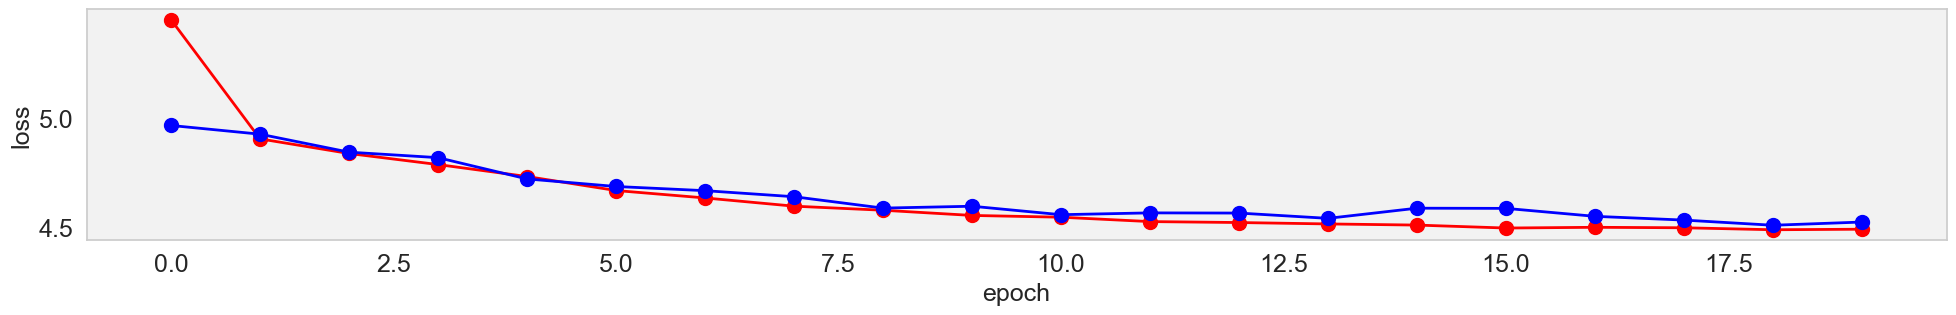

In [43]:
plt.figure(figsize=(24,3))
plt.plot(trn_hist, color='r', marker='o', ms=10, lw=2)
plt.plot(np.array(hold_hist), color='b', marker='o', ms=10, lw=2)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()

C:\Users\jiahaozhang\AppData\Local\Temp\ipykernel_55672\116228997.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0.5, 0, 'epoch')

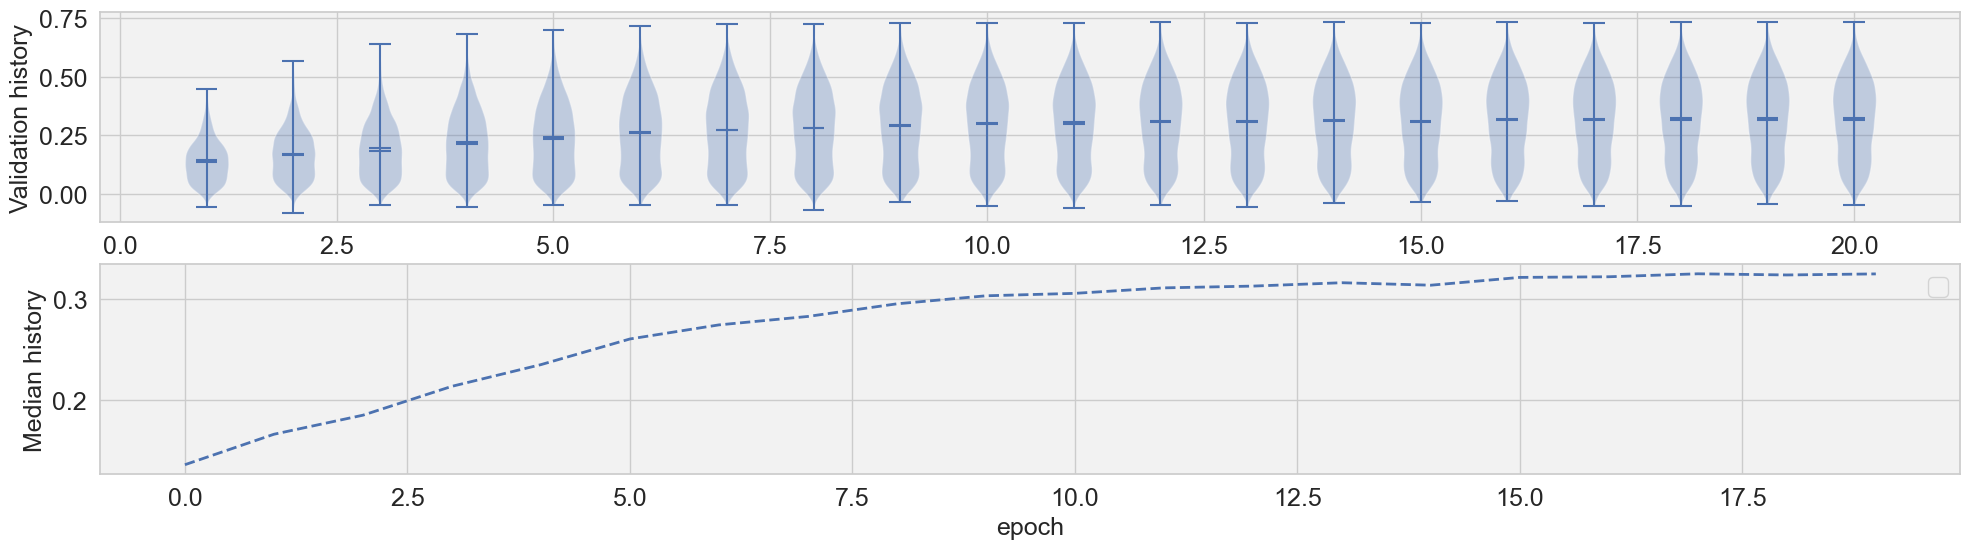

In [44]:
plt.figure(figsize=(24,6))
plt.subplot(2,1,1)
for s,cc in hold_cc_hist.items():
    plt.gca().violinplot(np.nan_to_num(np.array(cc)).T, showmeans=True, showmedians=True, showextrema=True)
plt.ylabel('Validation history')
plt.subplot(2,1,2)
for s in hold_cc_hist.keys():
    p=plt.plot([np.median(cc) for cc in hold_cc_hist[s]], lw=2, linestyle='--')
plt.legend()
plt.ylabel('Median history')
plt.xlabel('epoch')

---
## Final validation accuracy

In [46]:
val_voxel = {s: val_voxel_data[s] for s in val_voxel_data.keys()}
shared_model.load_state_dict(best_params['enc'])
shared_model.eval() 
for s,sd in subject_fwrfs.items():
    sd.load_state_dict(best_params['fwrfs'][s])
    sd.eval() 

batch_size = 100
subject_val_cc = validation_(_pred_fn, shared_model, subject_fwrfs, stim_data, val_voxel_data, val_stim_ordering, batch_size)
joined_val_cc = np.concatenate(list(subject_val_cc.values()), axis=0)

best joint score = 0.325
best joint val cc = 0.333
subject 1: val cc = 0.333


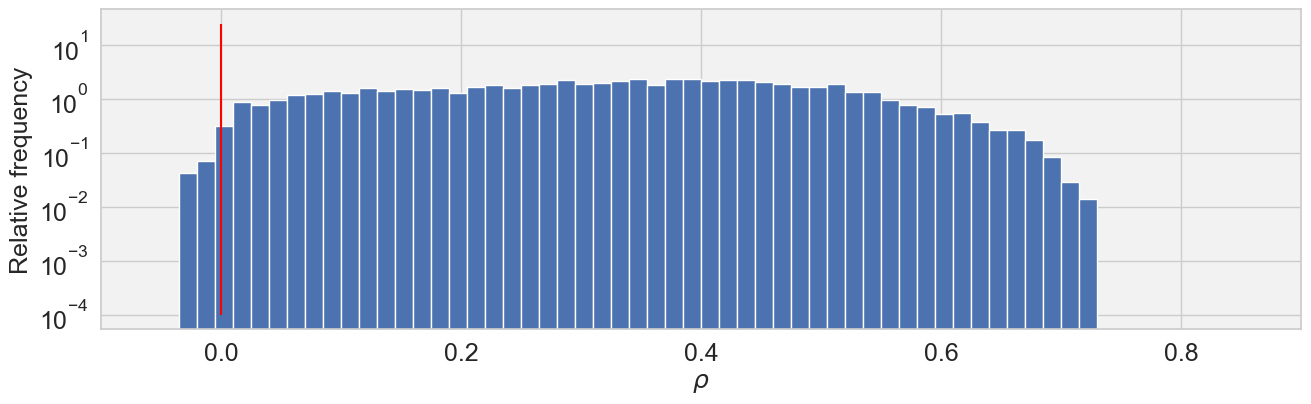

In [47]:
print ("best joint score = %.3f"%best_joint_cc_score)
print ("best joint val cc = %.3f"% np.median(joined_val_cc))
for s,v in subject_val_cc.items():
    print ("subject %s: val cc = %.3f"%(s, np.median(v)))

fig=plt.figure(figsize=(12,4))
plt.subplots_adjust(left=0., bottom=0.2, right=1., top=1., wspace=0., hspace=0.)
_=plt.hist(joined_val_cc, bins=100, density=True, range=(-.5, 1.))
_=plt.vlines(x=[0], ymin=1e-4, ymax=25, color='r')
_=plt.yscale('log')
_=plt.xlim([-.1, 0.9])
_=plt.xlabel(r'$\rho$')
_=plt.ylabel('Relative frequency')

# Save final parameters

In [48]:
torch.save({
            'num_epochs': num_epochs,
            'batch_size': batch_size,
            'holdout_frac': holdout_frac,   
            'best_params': best_params, 
            'final_params': final_params,
            'trn_loss_history': trn_hist,
            'hold_loss_history': hold_hist,
            'hold_cc_history': hold_cc_hist,
            'best_epoch': best_epoch,
            'best_joint_cc_score': best_joint_cc_score,
            'val_cc': subject_val_cc,
            'input_mean': trn_stim_mean,
            'brain_nii_shape': brain_nii_shape,
            'voxel_index': voxel_idx,
            'voxel_roi': voxel_roi,
            'voxel_mask': voxel_mask
            }, output_dir+'model_params_2')

In [49]:
print (output_dir)

C:/Data/nsd_test/output/multisubject/gnet8j_mpf_evc_May-04-2025_2344/


In [50]:
T.cuda.empty_cache()

In [51]:
gc.collect()

21649